### Image Classification with Intel Dataset

#### Authors
Muhammad Zaid, and Jiarui Zhao

The dataset I am using for this assignment is the [Intel Image Classification Dataset]{https://www.kaggle.com/datasets/puneet6060/intel-image-classification} found on kaggle. This dataset contains 25,000 images of 6 different classes: buildings, forest, glacier, mountain, sea, and street. </br>

In the next few code blocks I will showcase the properties of the dataset, especially the number of images per class, the size of the images, and the number of images in the training and test sets.

#### Install All Necessary Packages

In [2]:
%pip install "tensorflow-cpu"

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


#### Data Loading And Exploration

In [2]:
from PIL import Image

import numpy as np
import os

image = Image.open(os.getcwd()+'\\archive\\seg_train\\seg_train\\forest\\8.jpg')


print("Image Size of Images in Dataset: ", image.size)
print("Image Mode of Images in Dataset: ", image.mode)
imageCount:int = 0
classNum:list = []

for dirname, _, filenames in os.walk(os.getcwd()+'\\archive\\seg_train\\seg_train'):
    for filename in filenames:
        imageCount += 1
        
    
    classNum.append((imageCount, dirname.split('\\')[-1]))
    imageCount = 0
    

classNum.pop(0)    

print("Number of Images in Dataset: ", sum([i[0] for i in classNum]))
print("Number of Classes in Dataset: ", len(classNum))
print("Number of Images in each Class: ", classNum)


        




Image Size of Images in Dataset:  (150, 150)
Image Mode of Images in Dataset:  RGB
Number of Images in Dataset:  14034
Number of Classes in Dataset:  6
Number of Images in each Class:  [(2191, 'buildings'), (2271, 'forest'), (2404, 'glacier'), (2512, 'mountain'), (2274, 'sea'), (2382, 'street')]


As can be see in the ouput above the following is true:
- There are 6 classes of images
- Each class has an almosrt equal number of images
- The image size of each image is 150x150 pixels
- All images are in the RGB format


Now to display the distribution of the dataset

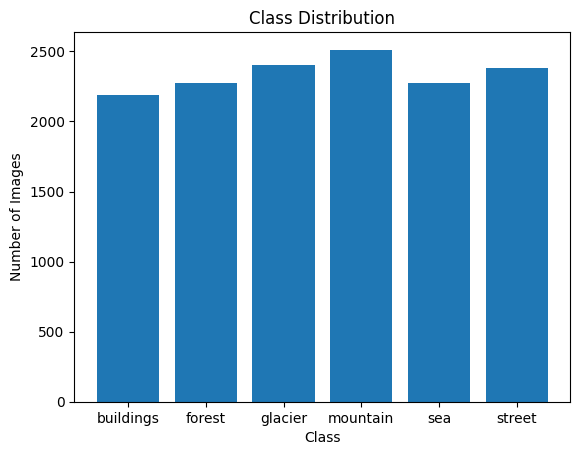

In [3]:
import matplotlib.pyplot as plt

# Extract the class names and values into separate lists
classes = [d[1] for d in classNum]
values = [d[0] for d in classNum]

# Create a bar chart of the values for each class
plt.bar(classes, values)

# Set the chart title and axis labels
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')

# Show the chart
plt.show()

Since we have an equal distribution of images per class, we can hope for high recall and precision for each class. </br>
The dataset with its six different classes can employ a multi class classification cnn model. </br>
So we would be predicting based on the images in the testing set which class the image belongs to. </br>

The dataset is split into a training, testing, and prediction set. The prediction set does not have any class labels. </br>

Lets show a image from each class, so that there is a visual representation of the classes.

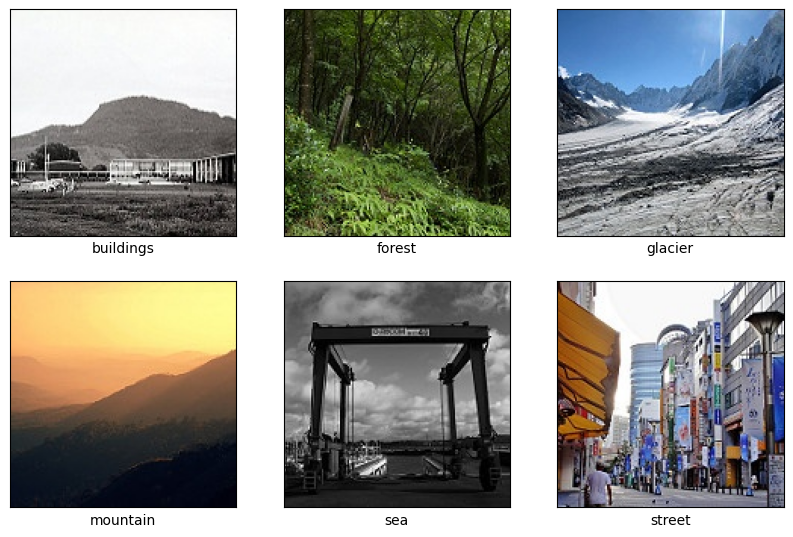

In [4]:
import glob

cwd = os.getcwd() + "\\archive\\seg_train\\seg_train\\"
subdirs = [f.path for f in os.scandir(cwd) if f.is_dir()]

listOfFiles:list = []

# Iterate over each subdirectory and find the first file
for subdir in subdirs:
    classname = os.path.basename(subdir)
    # Get a list of all files in the subdirectory
    files = glob.glob(subdir + '/*')
    if len(files) > 0:
        # Print the first file in the subdirectory
        listOfFiles.append((classname, files[0]))
        
plt.figure(figsize=(10,10))
for i in range(listOfFiles.__len__()):
    img = np.array(Image.open(listOfFiles[i][1]))
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img)
    plt.xlabel(listOfFiles[i][0])
plt.show()


Now I need to preprocess the image to convert all images into nuympy arrays and then normalize the images. This way I can directoly feed the images into the model. </br>

I also need to make sure that the dataset has a 80 to 20 split for training and testing. </br>

I will evaluate the results for two different models with and without color in the model. </br>



Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


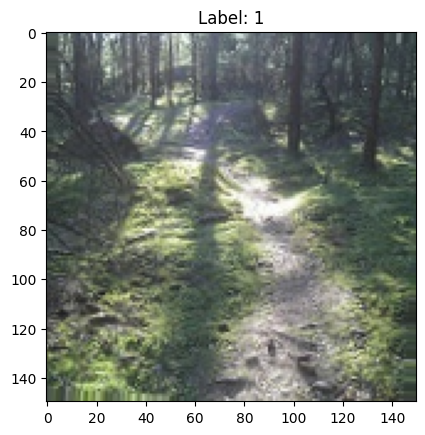

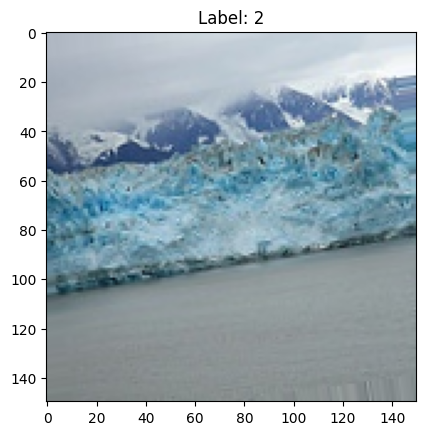

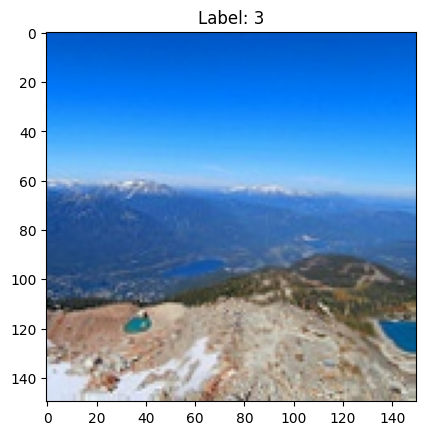

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_url = os.getcwd() + "\\archive\\seg_train\\seg_train\\"
test_url = os.getcwd() + "\\archive\\seg_test\\seg_test\\"


datagen = ImageDataGenerator(
    rescale=1./255,  # rescale pixel values to be between 0 and 1
    rotation_range=10,  # randomly rotate images by up to 20 degrees
    horizontal_flip=True)  # randomly flip images horizontally

train = datagen.flow_from_directory(train_url, target_size=(150, 150), batch_size=256, class_mode='categorical')
test = datagen.flow_from_directory(test_url, target_size=(150, 150), batch_size=256, class_mode='categorical')


images, labels = next(train)

# Display the properties of the first few images
for i in range(3):
    plt.imshow(images[i])
    plt.title('Label: {}'.format(np.argmax(labels[i])))
    plt.show()




The Labels for each image indicate a number from 0 to 5, representing a class. </br>
This datagen is for images with color. </br>

And as can be seen by the number of images for each train and test, the split is roughly around 80 to 20. </br>

#### Model Building

First, I will build a CNN based model for color images. </br>
The model will have 4 convolutional layers, 4 max pooling layers, a flatten layer, 2 dense layers, and a droupout layer. </br>

Second, I will build a CNN based model for grayscaler images. </br>

Third, I will build a CNN based model for color images with a different architecture. </br>
The model will have 3 convolutional layers, 3 max pooling layers, a flatten layer, 2 dense layers, and a droupout layer. </br>
I want to see how decreasing the convolutional layers affects the model. </br>

Fourth, I will use transfer learning to train a pretrained model on my dataset, could use RestNet or Yolo. </br>

I will then evaluate all the results for the models, to see which of these performed the best. </br>

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [9]:
from tensorflow import keras

optimizer = keras.optimizers.Adam(learning_rate=0.001)

if os.path.exists('models/image_classification_model_2.h5'):
    model = keras.models.load_model('models/image_classification_model_1.h5')
else:
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    fitted = model.fit(train, steps_per_epoch = 50 ,batch_size=128, epochs=10, validation_data=test, verbose=1)

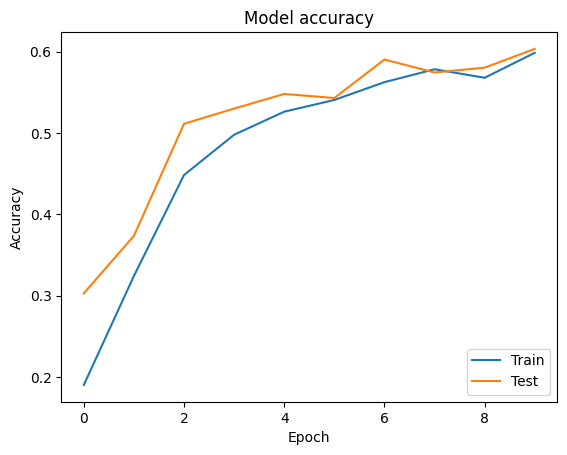

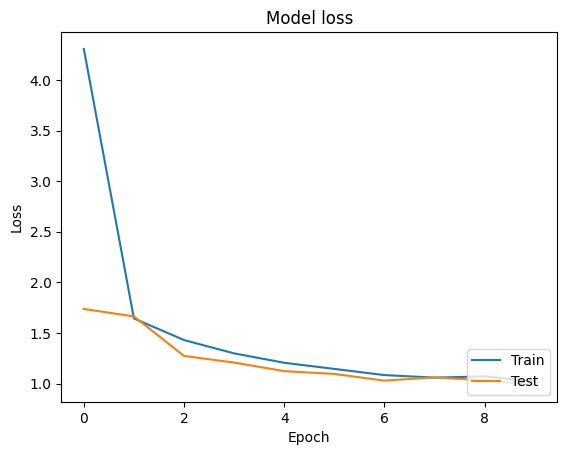

In [28]:
import random
from tensorflow.keras.preprocessing import image

model.save('models/image_classification_model_1.h5')

plt.plot(fitted.history['accuracy'])
plt.plot(fitted.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(fitted.history['loss'])
plt.plot(fitted.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

cwd = os.getcwd() + "\\archive\\seg_pred\\seg_pred\\"
img_names = os.listdir(cwd)
random_img_names = random.sample(img_names, 5)

class_dict = {0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}


Found 7301 images belonging to 1 classes.
8/8 [==============================] - 1s 71ms/step


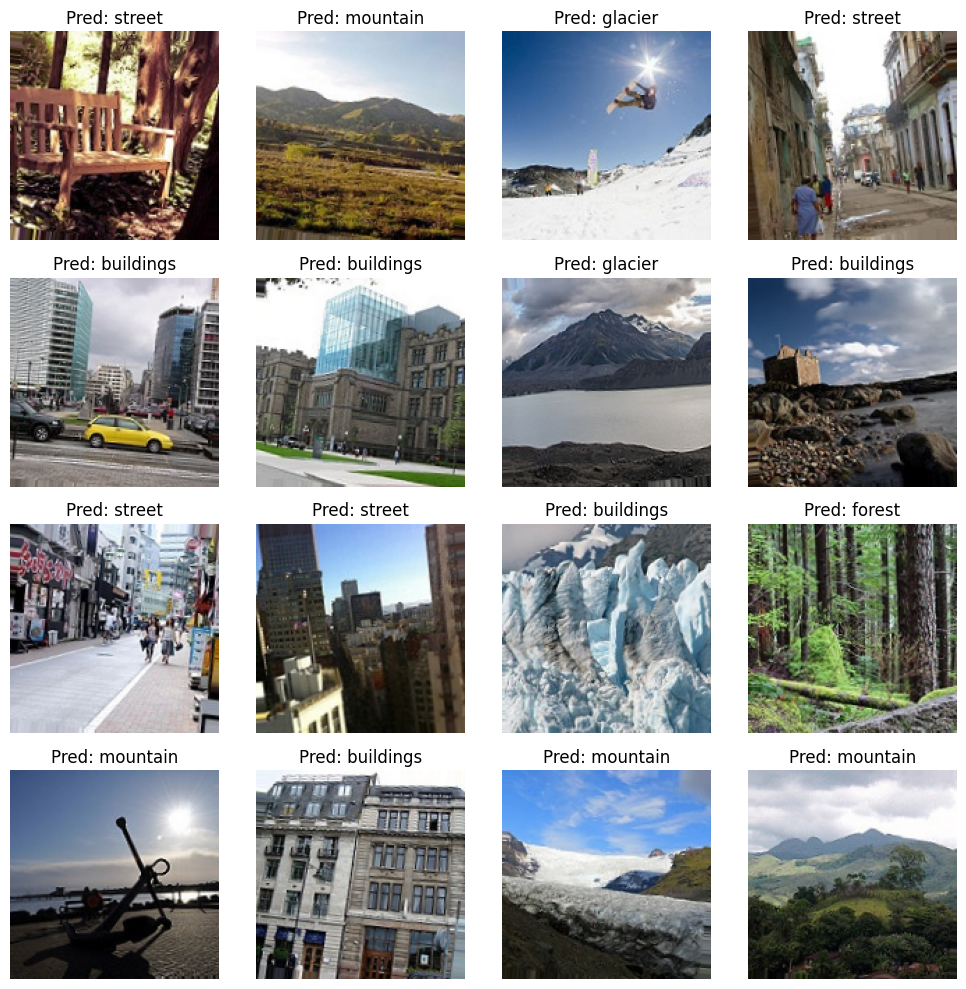

In [40]:
pred_url = os.getcwd() + "\\archive\\seg_pred"


datagen = ImageDataGenerator(
    rescale=1./255,  # rescale pixel values to be between 0 and 1
    rotation_range=10,  # randomly rotate images by up to 20 degrees
    horizontal_flip=True)  # randomly flip images horizontally

pred = datagen.flow_from_directory(pred_url, target_size=(150, 150), batch_size=256, class_mode='categorical')


import matplotlib.pyplot as plt
import numpy as np

# get the class labels
class_labels = list(train.class_indices.keys())

# get a batch of images and their predictions
x, _ = next(pred)
y_pred = model.predict(x)

# display the images and their predictions
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axs.flatten()):
    # show the image
    ax.imshow(x[i])
    ax.axis('off')
    
    # show the predicted label
    pred_label = class_labels[np.argmax(y_pred[i])]
    ax.set_title(f'Pred: {pred_label}')
    
plt.tight_layout()
plt.show()

First model done with the color images. </br>

Now to train the same model with the grayscale images. </br>
And then to train the same model with the color images but with a different architecture. </br>
And then finally transfer learning. </br>

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


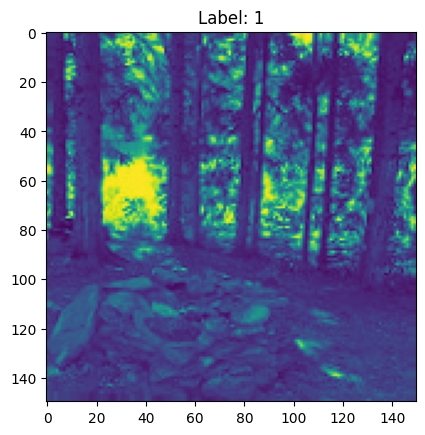

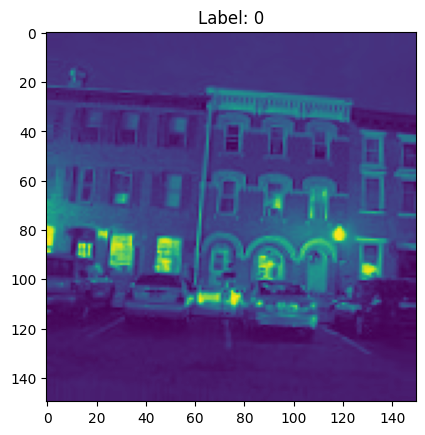

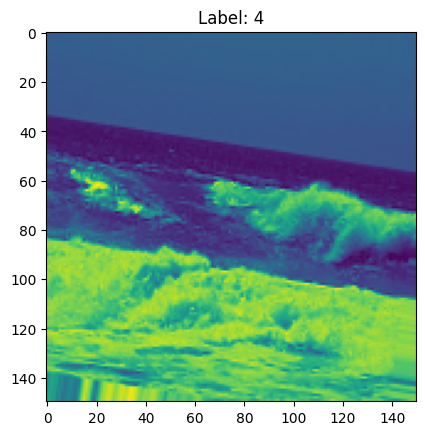

In [46]:
train_url = os.getcwd() + "\\archive\\seg_train\\seg_train\\"
test_url = os.getcwd() + "\\archive\\seg_test\\seg_test\\"


datagen = ImageDataGenerator(
    rescale=1./255,  # rescale pixel values to be between 0 and 1
    rotation_range=10,  # randomly rotate images by up to 20 degrees
    horizontal_flip=True)  # randomly flip images horizontally

train_gs = datagen.flow_from_directory(train_url, target_size=(150, 150), batch_size=128, class_mode='categorical', color_mode='grayscale')
test_gs = datagen.flow_from_directory(test_url, target_size=(150, 150), batch_size=128, class_mode='categorical', color_mode='grayscale')


images, labels = next(train_gs)

# Display the properties of the first few images
for i in range(3):
    plt.imshow(images[i])
    plt.title('Label: {}'.format(np.argmax(labels[i])))
    plt.show()




In [74]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 17, 17, 128)     

In [75]:
from tensorflow import keras

optimizer = keras.optimizers.Adam(learning_rate=0.001)

if os.path.exists('models/image_classification_model_2.h5'):
    model = keras.load_model('models/image_classification_model_2.h5')
else:
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    cnn_gray = model.fit(train_gs, steps_per_epoch=50, batch_size=128, epochs=10, validation_data=test_gs, verbose=1)
    model.save('models/image_classification_model_2.h5')

Epoch 1/10
50/50 [==============================] - 73s 1s/step - loss: 1.5865 - accuracy: 0.3155 - val_loss: 1.3255 - val_accuracy: 0.4690
Epoch 2/10
50/50 [==============================] - 70s 1s/step - loss: 1.2530 - accuracy: 0.4896 - val_loss: 1.1159 - val_accuracy: 0.5637
Epoch 3/10
50/50 [==============================] - 73s 1s/step - loss: 1.1027 - accuracy: 0.5598 - val_loss: 1.0181 - val_accuracy: 0.6030
Epoch 4/10
50/50 [==============================] - 74s 1s/step - loss: 1.0196 - accuracy: 0.6092 - val_loss: 0.9071 - val_accuracy: 0.6487
Epoch 5/10
50/50 [==============================] - 72s 1s/step - loss: 0.9427 - accuracy: 0.6388 - val_loss: 0.8662 - val_accuracy: 0.6697
Epoch 6/10
50/50 [==============================] - 72s 1s/step - loss: 0.8936 - accuracy: 0.6587 - val_loss: 0.8102 - val_accuracy: 0.6920
Epoch 7/10
50/50 [==============================] - 72s 1s/step - loss: 0.8247 - accuracy: 0.6837 - val_loss: 0.8457 - val_accuracy: 0.6713
Epoch 8/10
50/50 [==

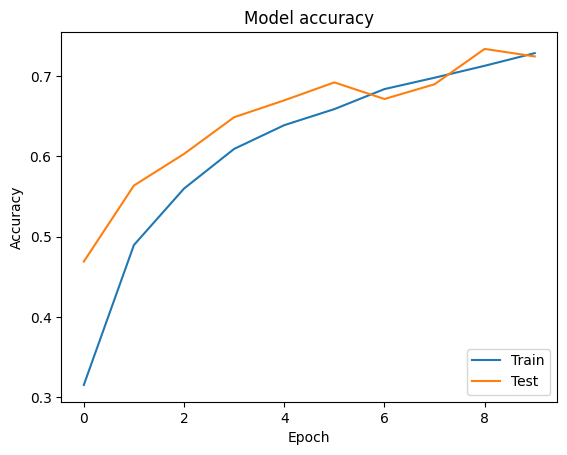

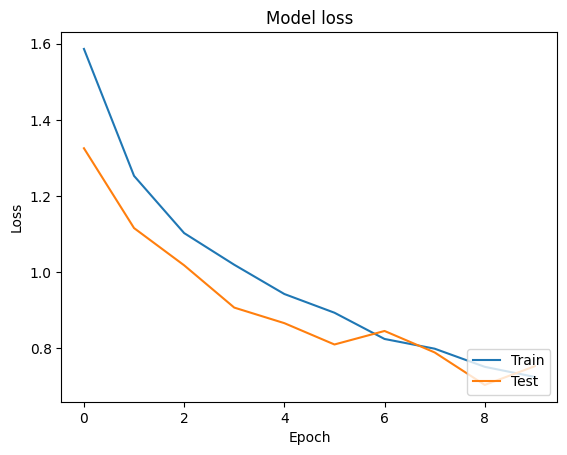

In [76]:
plt.plot(cnn_gray.history['accuracy'])
plt.plot(cnn_gray.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(cnn_gray.history['loss'])
plt.plot(cnn_gray.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

cwd = os.getcwd() + "\\archive\\seg_pred\\seg_pred\\"
img_names = os.listdir(cwd)
random_img_names = random.sample(img_names, 5)

class_dict = {0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}

Found 7301 images belonging to 1 classes.
8/8 [==============================] - 1s 74ms/step


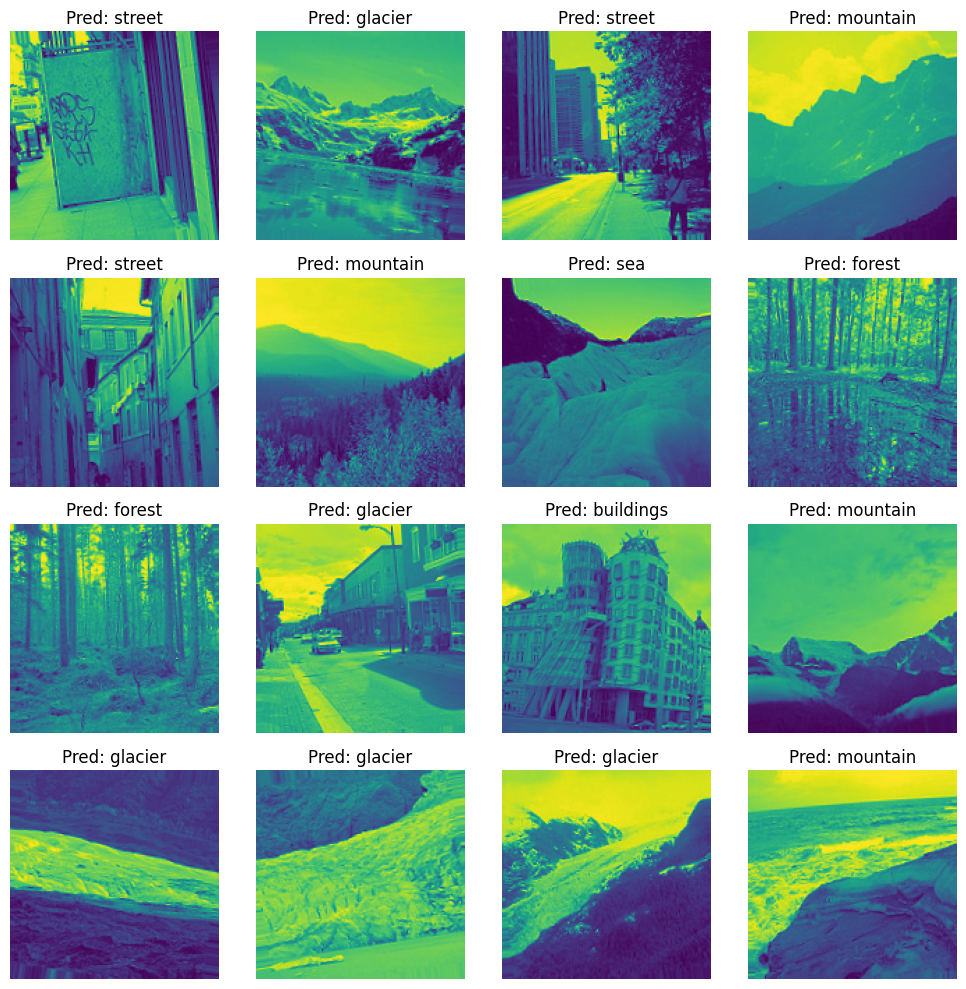

In [77]:
pred_url = os.getcwd() + "\\archive\\seg_pred"


datagen = ImageDataGenerator(
    rescale=1./255,  # rescale pixel values to be between 0 and 1
    rotation_range=10,  # randomly rotate images by up to 20 degrees
    horizontal_flip=True)  # randomly flip images horizontally

pred = datagen.flow_from_directory(pred_url, target_size=(150, 150), batch_size=256, class_mode='categorical', color_mode='grayscale')


import matplotlib.pyplot as plt
import numpy as np

# get the class labels
class_labels = list(train.class_indices.keys())

# get a batch of images and their predictions
x, _ = next(pred)
y_pred = model.predict(x)

# display the images and their predictions
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axs.flatten()):
    # show the image
    ax.imshow(x[i])
    ax.axis('off')
    
    # show the predicted label
    pred_label = class_labels[np.argmax(y_pred[i])]
    ax.set_title(f'Pred: {pred_label}')
    
plt.tight_layout()
plt.show()

Now to train with a different architecture. </br>

In [57]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 17, 17, 128)     

In [58]:
from tensorflow import keras

optimizer = keras.optimizers.Adam(learning_rate=0.001)

if os.path.exists('models/image_classification_model_3.h5'):
    model = keras.load_model('models/image_classification_model_3.h5')
    
else:
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    cnn = model.fit_generator(generator=train, steps_per_epoch=50, epochs=10, validation_data=test, verbose=1)
    model.save('models/image_classification_model_3.h5')

C:\Users\muzai\AppData\Local\Temp\ipykernel_11832\884340771.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn = model.fit_generator(generator=train, steps_per_epoch=50, epochs=10, validation_data=test, verbose=1)


Epoch 1/10
50/50 [==============================] - 138s 3s/step - loss: 1.2823 - accuracy: 0.4833 - val_loss: 0.9981 - val_accuracy: 0.6157
Epoch 2/10
50/50 [==============================] - 140s 3s/step - loss: 0.9582 - accuracy: 0.6215 - val_loss: 0.9331 - val_accuracy: 0.6407
Epoch 3/10
50/50 [==============================] - 133s 3s/step - loss: 0.8433 - accuracy: 0.6860 - val_loss: 0.7722 - val_accuracy: 0.7263
Epoch 4/10
50/50 [==============================] - 140s 3s/step - loss: 0.7264 - accuracy: 0.7300 - val_loss: 0.6657 - val_accuracy: 0.7597
Epoch 5/10
50/50 [==============================] - 143s 3s/step - loss: 0.6635 - accuracy: 0.7592 - val_loss: 0.6009 - val_accuracy: 0.7873
Epoch 6/10
50/50 [==============================] - 132s 3s/step - loss: 0.5851 - accuracy: 0.7871 - val_loss: 0.5387 - val_accuracy: 0.8157
Epoch 7/10
50/50 [==============================] - 135s 3s/step - loss: 0.5527 - accuracy: 0.7988 - val_loss: 0.5043 - val_accuracy: 0.8250
Epoch 8/10
50

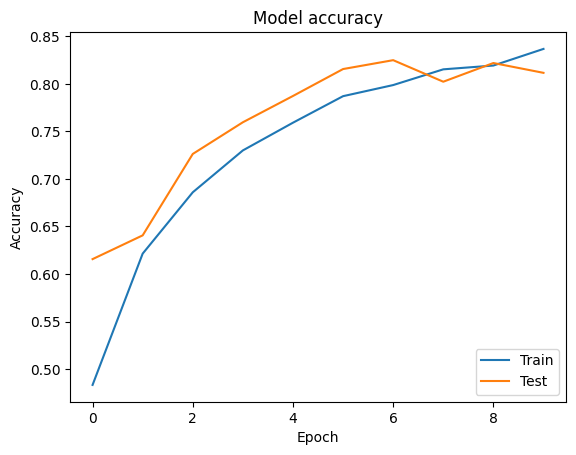

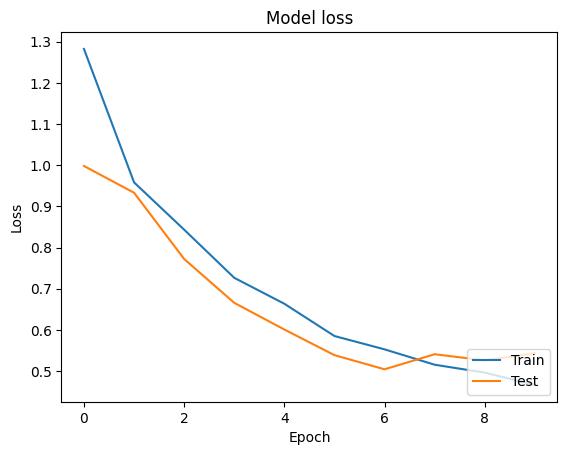

In [59]:
plt.plot(cnn.history['accuracy'])
plt.plot(cnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(cnn.history['loss'])
plt.plot(cnn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

cwd = os.getcwd() + "\\archive\\seg_pred\\seg_pred\\"
img_names = os.listdir(cwd)
random_img_names = random.sample(img_names, 5)

class_dict = {0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}

Found 7301 images belonging to 1 classes.
8/8 [==============================] - 1s 75ms/step


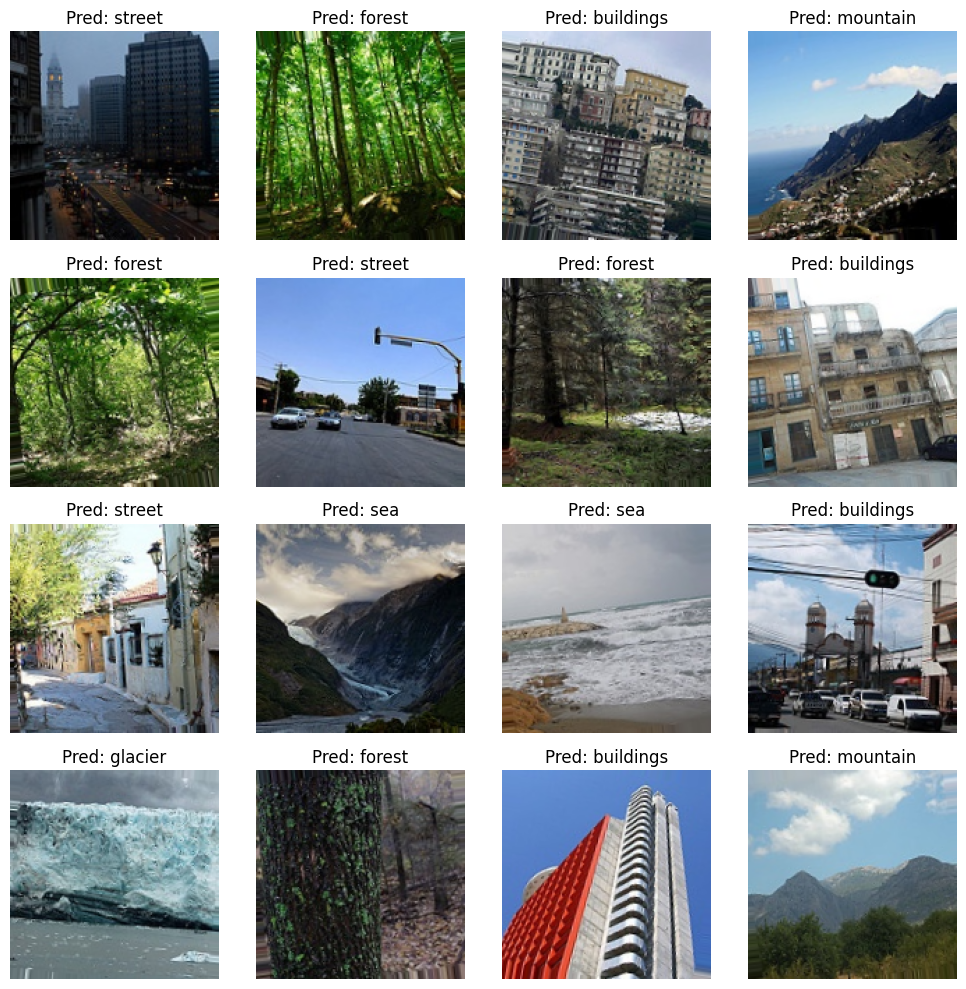

In [60]:
pred_url = os.getcwd() + "\\archive\\seg_pred"


datagen = ImageDataGenerator(
    rescale=1./255,  # rescale pixel values to be between 0 and 1
    rotation_range=10,  # randomly rotate images by up to 20 degrees
    horizontal_flip=True)  # randomly flip images horizontally

pred = datagen.flow_from_directory(pred_url, target_size=(150, 150), batch_size=256, class_mode='categorical')


import matplotlib.pyplot as plt
import numpy as np

# get the class labels
class_labels = list(train.class_indices.keys())

# get a batch of images and their predictions
x, _ = next(pred)
y_pred = model.predict(x)

# display the images and their predictions
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axs.flatten()):
    # show the image
    ax.imshow(x[i])
    ax.axis('off')
    
    # show the predicted label
    pred_label = class_labels[np.argmax(y_pred[i])]
    ax.set_title(f'Pred: {pred_label}')
    
plt.tight_layout()
plt.show()

Now to use transfer learning. </br>

In [79]:
import tensorflow as tf

base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top = False)

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
preds = tf.keras.layers.Dense(6, activation ='softmax')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=preds)
print(model.summary())


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_4[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                         

In [81]:
datagen = ImageDataGenerator(
    rescale=1./255,  # rescale pixel values to be between 0 and 1
    rotation_range=10,  # randomly rotate images by up to 20 degrees
    horizontal_flip=True)  # randomly flip images horizontally

train = datagen.flow_from_directory(train_url, target_size=(150, 150), batch_size=128, class_mode='categorical')
test = datagen.flow_from_directory(test_url, target_size=(150, 150), batch_size=128, class_mode='categorical')

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

if os.path.exists('models/image_classification_model_5.h5'):
    model = tf.keras.models.load_model('models/image_classification_model_4.h5')

else:
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
    cnn = model.fit(train, steps_per_epoch=50, epochs = 10, validation_data=test, verbose=1,  callbacks=[callback])
    model.save('models/image_classification_model_4.h5')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Epoch 1/10
50/50 [==============================] - 661s 13s/step - loss: 0.3220 - accuracy: 0.8961 - val_loss: 12.8451 - val_accuracy: 0.4183
Epoch 2/10
50/50 [==============================] - 694s 14s/step - loss: 0.3035 - accuracy: 0.8977 - val_loss: 3.7855 - val_accuracy: 0.2560
Epoch 3/10
50/50 [==============================] - 632s 13s/step - loss: 0.2555 - accuracy: 0.9198 - val_loss: 1.6775 - val_accuracy: 0.4030
Epoch 4/10
50/50 [==============================] - 653s 13s/step - loss: 0.2665 - accuracy: 0.9156 - val_loss: 1.5976 - val_accuracy: 0.4340
Epoch 5/10
50/50 [==============================] - 690s 14s/step - loss: 0.2424 - accuracy: 0.9187 - val_loss: 1.1986 - val_accuracy: 0.5443
Epoch 6/10
50/50 [==============================] - 599s 12s/step - loss: 0.2225 - accuracy: 0.9252 - val_loss: 1.1079 - val_accuracy: 0.6403
Epoch 7/10
50/50 [==============================] - 568s 11s/s

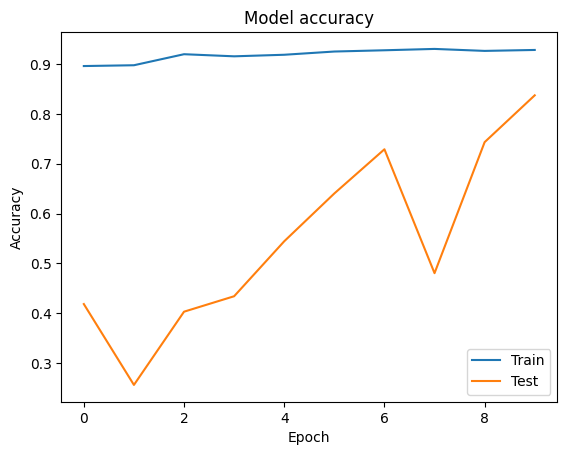

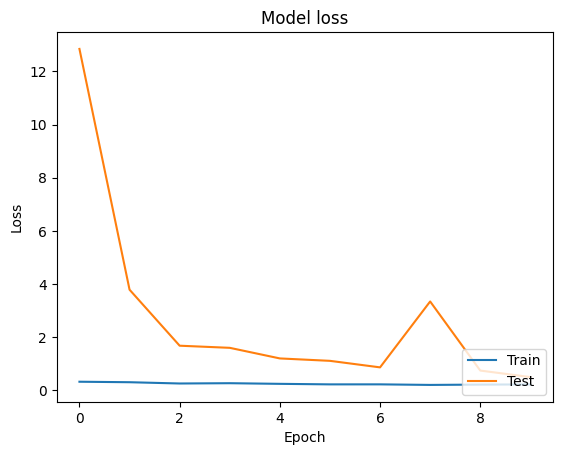

In [82]:
plt.plot(cnn.history['accuracy'])
plt.plot(cnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(cnn.history['loss'])
plt.plot(cnn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

Found 7301 images belonging to 1 classes.
8/8 [==============================] - 5s 559ms/step


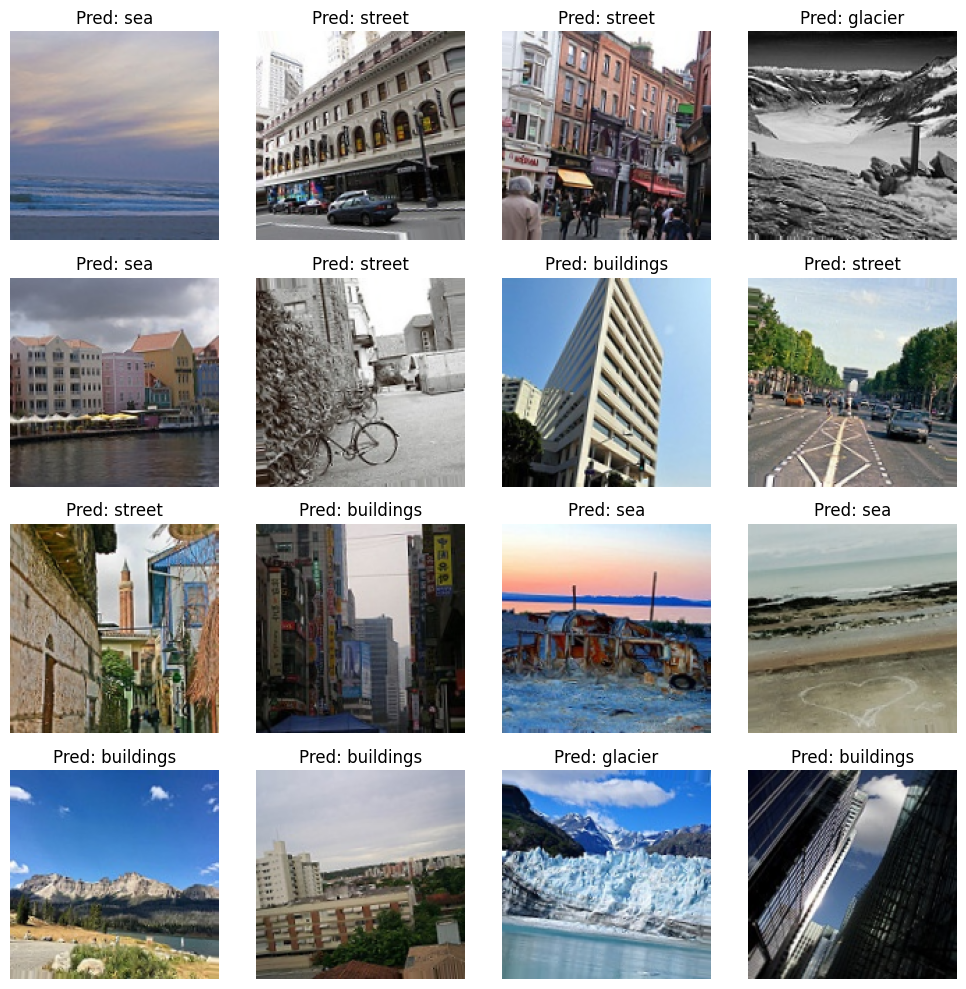

In [83]:
pred_url = os.getcwd() + "\\archive\\seg_pred"


datagen = ImageDataGenerator(
    rescale=1./255,  # rescale pixel values to be between 0 and 1
    rotation_range=10,  # randomly rotate images by up to 20 degrees
    horizontal_flip=True)  # randomly flip images horizontally

pred = datagen.flow_from_directory(pred_url, target_size=(150, 150), batch_size=256, class_mode='categorical')


import matplotlib.pyplot as plt
import numpy as np

# get the class labels
class_labels = list(train.class_indices.keys())

# get a batch of images and their predictions
x, _ = next(pred)
y_pred = model.predict(x)

# display the images and their predictions
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axs.flatten()):
    # show the image
    ax.imshow(x[i])
    ax.axis('off')
    
    # show the predicted label
    pred_label = class_labels[np.argmax(y_pred[i])]
    ax.set_title(f'Pred: {pred_label}')
    
plt.tight_layout()
plt.show()

#### Model Evaluation

As can be seen in all the models above, the accuracy for the sequential model with color images and 4 conv2d layers has the lowest accuracy. </br>
With just a simple change in using grayscale images, the accuracy jumps 10% with it going from 50 to 62. </br>

The deep learning model seems to work better with less layers since the accuracy for the 3 conv2d layer model was around 65%, far higher than the 4conv2d layer model. Note that there were no other changes made to origrinal architecture, even the color input was kept the same.</br>

The amount of learning parameters as well as the number of images quite affected the training time of these models. It took an hour each to train most of them, especially because some used to stall out for some reason. </br>

The model that performed best was the transfer learning model, with an accuracy of 86%. I could not let it run for longer because of problems with time, since every epoch seemed to take around 10 minutes, and I could not let it run continously external problems. Otherwise I think it would have definitely performed better than what is seen here.</br>